# <a id="top">**Table of Contents**</a>  
1. <a href="#group-9-take-home-assessment">Group-9 Take-Home Assessment</a>  
2. <a href="#strategies">Strategies</a>  
   - <a href="#strategy-1">1. Simple Moving Average Crossover</a>  
   - <a href="#strategy-2">2. Relative Strength Index + Simple Moving Average</a>  
   - <a href="#strategy-3">3. Mean Reversion</a>  
   - <a href="#strategy-4">4. SMA + Bollinger Bands</a>  
   - <a href="#strategy-5">5. Moving Average Convergence Divergence + Simple Moving Average</a>  
   - <a href="#strategy-6">6. KDJ + Moving Average Convergence Divergence</a>  
3. <a href="#best-three-strategies-and-their-results">Best Three Strategies and Their Results</a>  
4. <a href="#critiques">Critiques</a>  
5. <a href="#contribution-statement">Contribution Statement</a>  


## <a id="group-9-take-home-assessment">**Group-9**</a> 
### Group Members

1. PHOO PYAE HSU MYAT - 01520414
2. LU TINGJIA - 01499229
3. ZHANG YONGHAN - 01500212 
4. LI RUOYAO - 01512273

### Objective
- Build trading strategies using the past 20 years (November 2005 through October 2024) of S&P 500 data `SPY`
- Starting capital = `$100,000`
- Performence Metrics - `Sharpe Ratio`, `Compound Annual growth rate`, `Maximum drawdown`, and `Final Capital`

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader.data as pdr
import pandas_ta as ta
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings("ignore")

In [2]:
initial_capital = 1e5

start_date = dt.date(2005,11,1)
end_date = dt.date(2024,11,1)

spy_data = yf.download("SPY", start=start_date, end=end_date)
spy_data["log_return"] = np.log(spy_data["Adj Close"] / spy_data["Adj Close"].shift(1))

validation_size = 0.20

train_size =\
    int(len(spy_data) 
        * 
        (1 - validation_size)
       )

spy_train, spy_test =\
    (spy_data[0         :train_size], 
     spy_data[train_size:len(spy_data)    ]
    )

[*********************100%%**********************]  1 of 1 completed


In [3]:
def calculate_metrics(data):
        # Calculate the number of days
        days = (data.index[-1] - data.index[0]).days

        # Calculate Sharpe Ratio
        strategy_returns = data["strategy_return"].dropna()
        sharpe_ratio = (
            np.sqrt(252) *
            (strategy_returns.apply(np.exp).mean() - 1) /
            strategy_returns.apply(np.exp).std()
        )

        # Calculate CAGR
        cagr = (
            data["strategy_cumulative_return"].iloc[-1]
        ) ** (365.0 / days) - 1

        # Calculate Final Capital
        final_capital = (
            data["strategy_cumulative_return"].iloc[-1] 
            * initial_capital
        )

        # Calculate Max Drawdown
        max_drawdown = (
            (data["strategy_cumulative_return"].cummax() - 
            data["strategy_cumulative_return"])
            .max()
        )

        # Compile metrics into a dictionary
        metrics = {
            "Sharpe Ratio": sharpe_ratio,
            "CAGR": cagr,
            "Final Capital": final_capital,
            "Max Drawdown": max_drawdown,
        }

        return metrics

In [4]:
def visualize_returns(strategy_df):

    plt.figure(figsize=(12, 6))
    
    # Plot benchmark cumulative return
    plt.plot(benchmark_df.index, benchmark_df["cumulative_return"], label="Benchmark", linewidth=2)
    
    # Plot strategy cumulative return
    plt.plot(strategy_df.index, strategy_df["strategy_cumulative_return"], label="Strategy Return", linewidth=2, linestyle='--')
    
    # Add title and labels
    plt.title("Cumulative Returns: Benchmark vs. Strategy", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Cumulative Return", fontsize=12)
    
    # Add grid and legend
    plt.grid(True)
    plt.legend(fontsize=10)
    
    # Show the plot
    plt.show()

In [5]:
def calculate_performance_metrics(data, initial_capital=100000):

   # Ensure required columns exist
    if "positions" not in data.columns or "log_return" not in data.columns:
        raise ValueError("Input data must contain 'positions' and 'log_return' columns.")

    # Calculate strategy returns
    data["strategy_return"] = data["positions"].shift(1) * data["log_return"]

    # Calculate strategy cumulative returns
    data["strategy_cumulative_return"] = np.exp(data["strategy_return"].cumsum())

    metrics = calculate_metrics(data)

    return metrics

In [6]:
benchmark_df = pd.DataFrame()

benchmark_df["log_return"] = spy_data[["log_return"]]
benchmark_df["positions"] = 1

benchmark_metrices = calculate_performance_metrics(benchmark_df)
benchmark_df = benchmark_df.drop(columns=["strategy_return"])
benchmark_df = benchmark_df.rename(columns={"strategy_cumulative_return": "cumulative_return"})

benchmark_metrices

{'Sharpe Ratio': 0.6177659392162043,
 'CAGR': 0.10583616227167969,
 'Final Capital': 677023.5439700482,
 'Max Drawdown': 1.3378779025062428}

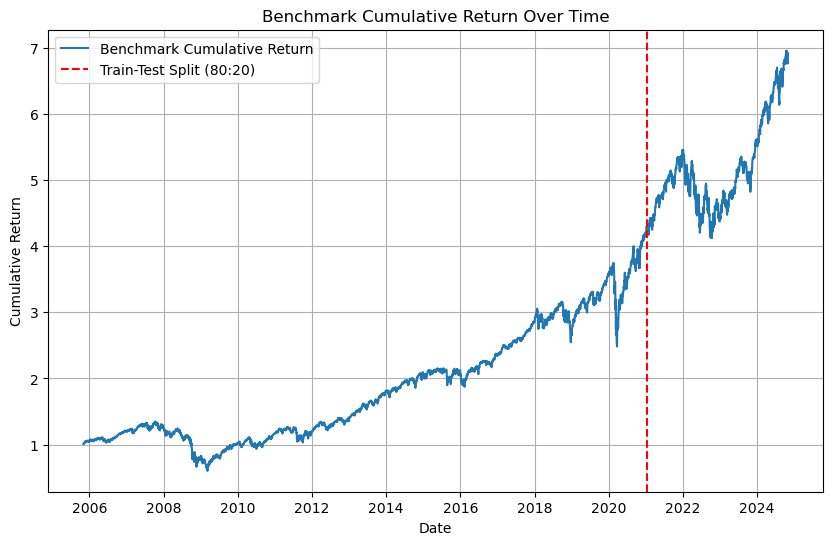

In [7]:
split_index = int(len(benchmark_df) * 0.8)

plt.figure(figsize=(10, 6))
plt.plot(benchmark_df.index, benchmark_df["cumulative_return"], label="Benchmark Cumulative Return")
plt.axvline(benchmark_df.index[split_index], color='red', linestyle='--', label="Train-Test Split (80:20)")

plt.title("Benchmark Cumulative Return Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

## <a id="strategies">**Strategies**</a>

In [8]:
def optimize_strategy(data, strategy_function, param_bounds):

    def objective(**params):
        # Convert parameters to appropriate types
        params = {key: int(value) for key, value in params.items()}  # Ensure integer SMA windows
        try:
            # Run the strategy function
            result = strategy_function(data.copy(), **params)

            # Check if result is a tuple and contains two elements
            if not isinstance(result, tuple) or len(result) != 2:
                raise ValueError("strategy_function must return a tuple (data, metrics).")

            strategy_data, metrics = result

            # Use Final Capital as the target to maximize
            return metrics.get("Final Capital", -np.inf)  # Penalize missing 'Final Capital'
        except Exception as e:
            return -np.inf  # Penalize invalid parameter sets

    # Set up Bayesian Optimization with reduced verbosity
    optimizer = BayesianOptimization(
        f=objective,
        pbounds=param_bounds,
        random_state=42,
        verbose=0  # Suppress iteration logs
    )

    optimizer.maximize(init_points=10, n_iter=50)

    optimal_params = {key: int(value) for key, value in optimizer.max["params"].items()}
    optimal_data, _ = strategy_function(data.copy(), **optimal_params)
    optimal_metrics = calculate_metrics(optimal_data)

    return {"params": optimal_params, "metrics": optimal_metrics}

### <a id="strategy-1">1. Simple Moving Average Crossover</a>
[🔝 Back to Table of Contents](#top)

In [9]:
def sma_crossover_strategy(data, short_sma=10, long_sma=50):

    data = data.copy()

    # Ensure required column exists
    if "Adj Close" not in data.columns:
        raise ValueError("Input data must contain 'Adj Close' column.")

    # Calculate short-term and long-term SMAs
    data["SMA_Short"] = data["Adj Close"].rolling(window=short_sma).mean()
    data["SMA_Long"] = data["Adj Close"].rolling(window=long_sma).mean()

    # Define positions based on SMA crossover
    data["positions"] = 0
    data["positions"] =\
    (
        np
        .where(data["SMA_Short"] > data["SMA_Long"],
               1, -1)
    )

    calculated_metrics = calculate_performance_metrics(data)

    return data, calculated_metrics

In [10]:
sma_param_bounds = {
    "short_sma": (5, 20),
    "long_sma": (21, 100)
}

In [11]:
optimize_strategy(spy_train, sma_crossover_strategy, sma_param_bounds)

{'params': {'long_sma': 78, 'short_sma': 10},
 'metrics': {'Sharpe Ratio': 0.5620106587017292,
  'CAGR': 0.09676501408338556,
  'Final Capital': 407433.0394615105,
  'Max Drawdown': 0.9919103454456555}}

{'Sharpe Ratio': 0.5165811545680579, 'CAGR': 0.08466137319600775, 'Final Capital': 468787.58221541246, 'Max Drawdown': 1.043651648661323}


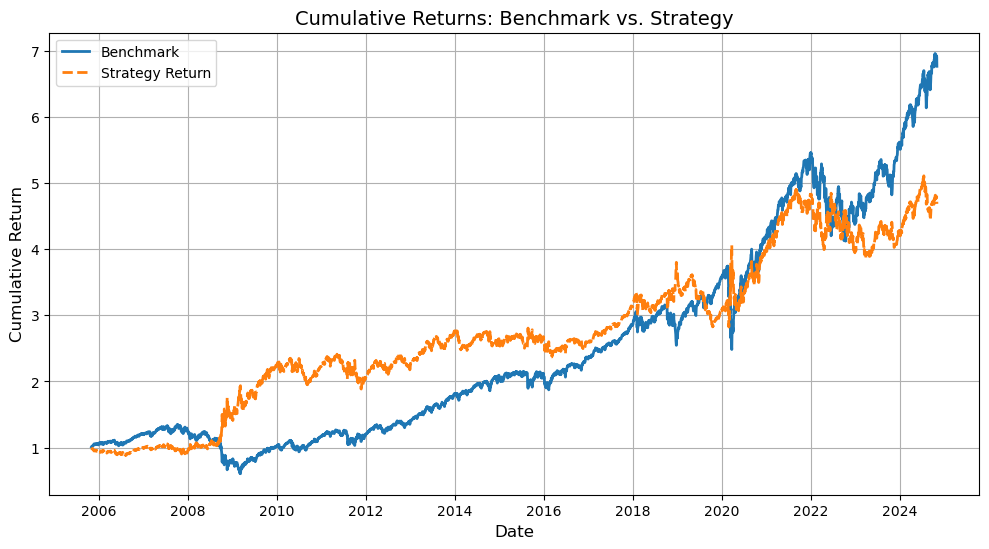

In [12]:
sma_df, sma_metrices = sma_crossover_strategy(spy_data,10,78)
print(sma_metrices)
visualize_returns(sma_df)

### <a id="strategy-2">2. Relative Strength Index + Simple Moving Average</a>
[🔝 Back to Table of Contents](#top)

In [13]:
def rsi_sma_strategy(data, rsi_period=14, sma_period=50, buy_threshold=30):

    data = data.copy()

    # Ensure required column exists
    if "Adj Close" not in data.columns:
        raise ValueError("Input data must contain 'Adj Close' column.")

    # --- RSI Calculation ---
    delta = data["Adj Close"].diff()  # Calculate price changes
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()  # Average gains
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()  # Average losses
    rs = gain / loss  # Relative Strength
    data["RSI"] = 100 - (100 / (1 + rs))  # Relative Strength Index

    # --- SMA Calculation ---
    data["SMA"] = data["Adj Close"].rolling(window=sma_period).mean()

    rsi_buy = buy_threshold
    rsi_sell = 100 - buy_threshold

    # --- Trading Logic ---
    data["positions"] = 0
    # Buy Signal: RSI below rsi_buy and Price > SMA (bullish trend)
    data.loc[(data["RSI"] < rsi_buy) & (data["Adj Close"] > data["SMA"]), "positions"] = 1
    # Sell Signal: RSI above rsi_sell and Price < SMA (bearish trend)
    data.loc[(data["RSI"] > rsi_sell) & (data["Adj Close"] < data["SMA"]), "positions"] = -1

    # Calculate performance metrics
    metrics = calculate_performance_metrics(data)

    # Drop NaN values created by rolling calculations
    data = data.dropna(subset=["RSI", "SMA", "positions"])

    return data, metrics


In [14]:
rsi_sma_param_bounds = {
    "rsi_period": (7, 30),     
    "sma_period": (20, 200),  
    "buy_threshold": (10, 40),       
}

In [15]:
optimize_strategy(spy_train, rsi_sma_strategy, rsi_sma_param_bounds)

{'params': {'buy_threshold': 39, 'rsi_period': 8, 'sma_period': 196},
 'metrics': {'Sharpe Ratio': 0.7023955274113245,
  'CAGR': 0.061352209374587074,
  'Final Capital': 236171.44334512204,
  'Max Drawdown': 0.5754777450749353}}

{'Sharpe Ratio': 0.6203880006810899, 'CAGR': 0.05250613870982024, 'Final Capital': 264552.37859468994, 'Max Drawdown': 0.6114824759914699}


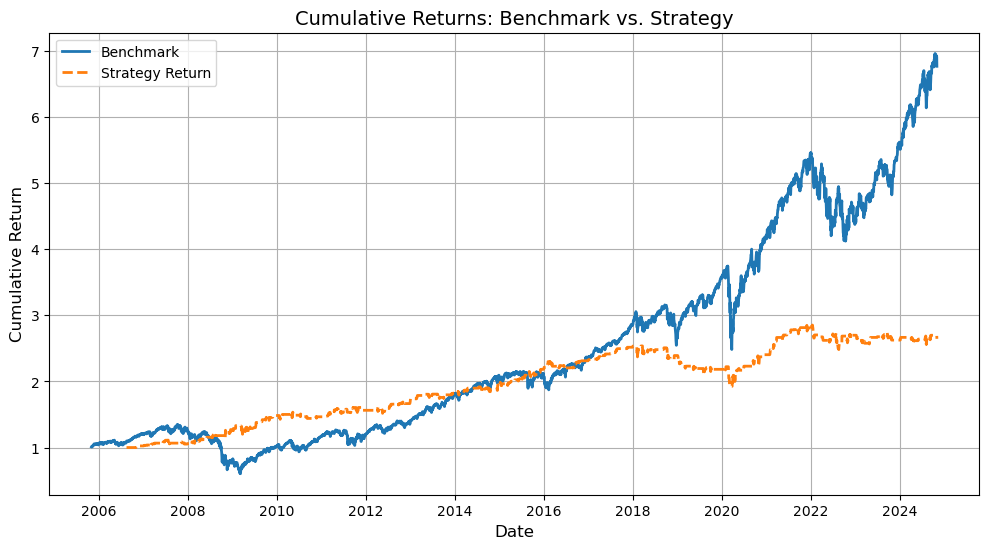

In [16]:
rsi_sma_df, rsi_sma_metrices = rsi_sma_strategy(spy_data,8,200,40)
print(rsi_sma_metrices)
visualize_returns(rsi_sma_df)

### <a id="strategy-3">3. Mean Reversion</a>
[🔝 Back to Table of Contents](#top)

In [17]:
def mean_reversion_strategy(data, lookback=20, threshold=2):
    data = data.copy()

    # Ensure required column exists
    if "Adj Close" not in data.columns:
        raise ValueError("Input data must contain 'Adj Close' column.")

    # Calculate moving average and standard deviation
    data["moving_avg"] = data["Adj Close"].rolling(window=lookback).mean()
    data["moving_std"] = data["Adj Close"].rolling(window=lookback).std()

    # Calculate Z-score
    data["z_score"] = (data["Adj Close"] - data["moving_avg"]) / data["moving_std"]

    # Define positions based on Z-score thresholds
    data["positions"] = 0
    data.loc[data["z_score"] < -threshold, "positions"] = 1  # Oversold: Buy
    data.loc[data["z_score"] > threshold, "positions"] = -1  # Overbought: Sell

    # Ensure no NaN values remain in critical columns
    data = data.dropna(subset=["z_score", "positions"])

    calculated_metrics = calculate_performance_metrics(data)

    return data, calculated_metrics

In [18]:
mr_param_bounds = {
    "lookback": (10, 50),
    "threshold": (1, 3)  
}

In [19]:
optimize_strategy(spy_train, mean_reversion_strategy, mr_param_bounds)

{'params': {'lookback': 13, 'threshold': 1},
 'metrics': {'Sharpe Ratio': 0.5926456423835452,
  'CAGR': 0.08217424230772896,
  'Final Capital': 331204.1620313942,
  'Max Drawdown': 2.001876397450215}}

{'Sharpe Ratio': 0.5334016794896497, 'CAGR': 0.06980447215540142, 'Final Capital': 359600.54362812237, 'Max Drawdown': 2.001876397450215}


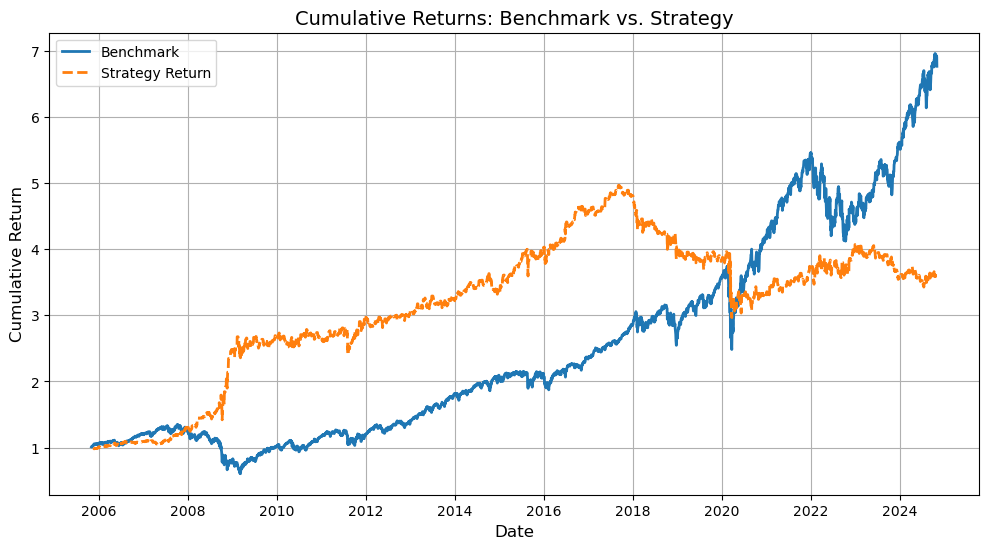

In [20]:
mr_df, mr_metrices = mean_reversion_strategy(spy_data,13,1)
print(mr_metrices)
visualize_returns(mr_df)

### <a id="strategy-4">4. SMA+Bollinger Bands</a>
[🔝 Back to Table of Contents](#top)

In [21]:
def sma_bollinger_strategy(data, short_window=50, long_window=200, bollinger_window=20, num_std=2):

    data = data.copy()

    # Ensure "Adj Close" exists
    if "Adj Close" not in data.columns:
        raise ValueError("Input data must contain 'Adj Close' column.")

    # --- SMA Calculation ---
    data["short_sma"] = data["Adj Close"].rolling(window=short_window).mean()
    data["long_sma"] = data["Adj Close"].rolling(window=long_window).mean()

    # --- Bollinger Bands Calculation ---
    data["rolling_mean"] = data["Adj Close"].rolling(window=bollinger_window).mean()
    data["rolling_std"] = data["Adj Close"].rolling(window=bollinger_window).std()
    data["upper_band"] = data["rolling_mean"] + (num_std * data["rolling_std"])
    data["lower_band"] = data["rolling_mean"] - (num_std * data["rolling_std"])

    # --- Trading Logic ---
    data["positions"] = 0

    # Buy Signal: Price closes below lower Bollinger Band + Golden Cross (short SMA > long SMA)
    data.loc[
        (data["Adj Close"] < data["lower_band"]) & (data["short_sma"] > data["long_sma"]),
        "positions",
    ] = 1

    # Sell Signal: Price closes above upper Bollinger Band + Death Cross (short SMA < long SMA)
    data.loc[
        (data["Adj Close"] > data["upper_band"]) & (data["short_sma"] < data["long_sma"]),
        "positions",
    ] = -1

    # Drop NaN values created by rolling calculations
    data = data.dropna()

    # Calculate performance metrics
    metrics = calculate_performance_metrics(data)

    return data, metrics

In [22]:
sma_bollinger_param_bounds = {
    "short_window": (10, 100),   
    "long_window": (50, 300),     
    "bollinger_window": (10, 50),  
    "num_std": (1, 3),            
}

In [23]:
optimize_strategy(spy_train, sma_bollinger_strategy, sma_bollinger_param_bounds)

{'params': {'bollinger_window': 11,
  'long_window': 122,
  'num_std': 1,
  'short_window': 64},
 'metrics': {'Sharpe Ratio': 0.7368764235279271,
  'CAGR': 0.07485062533456,
  'Final Capital': 289432.4976966785,
  'Max Drawdown': 0.42896869570006935}}

{'Sharpe Ratio': 0.7107000806713017, 'CAGR': 0.06878181645278714, 'Final Capital': 342925.2392124629, 'Max Drawdown': 0.42896869570006935}


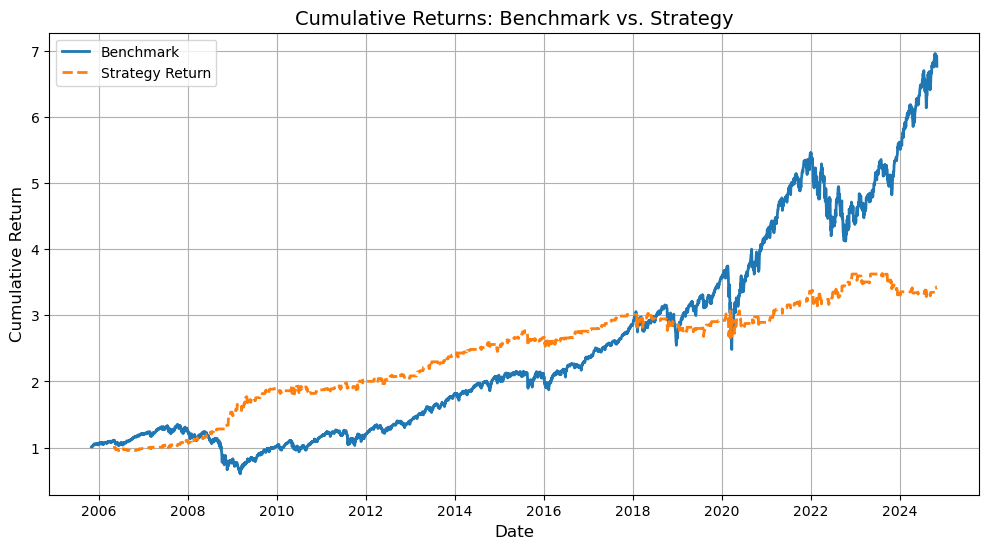

In [24]:
sma_bollinger_df, sma_bollinger_metrices = sma_bollinger_strategy(spy_data,64,122,11,1)
print(sma_bollinger_metrices)
visualize_returns(sma_bollinger_df)

### <a id="strategy-5">5. Moving Average Convergence Divergence + Simple Moving Average</a>
[🔝 Back to Table of Contents](#top)

In [25]:
def macd_sma_strategy(data, short_window=12, long_window=26, signal_window=9, sma_window=50):

    data = data.copy()

    # Ensure required column exists
    if "Adj Close" not in data.columns:
        raise ValueError("Input data must contain 'Adj Close' column.")

    # Calculate EMAs for MACD
    data["ema_short"] = data["Adj Close"].ewm(span=short_window, adjust=False).mean()
    data["ema_long"] = data["Adj Close"].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD and Signal Line
    data["macd"] = data["ema_short"] - data["ema_long"]
    data["signal_line"] = data["macd"].ewm(span=signal_window, adjust=False).mean()

    # Calculate SMA
    data["sma"] = data["Adj Close"].rolling(window=sma_window).mean()

    # Define positions
    data["positions"] = 0
    # Buy Signal: MACD crosses above Signal Line AND Price > SMA
    data.loc[(data["macd"] > data["signal_line"]) & (data["Adj Close"] > data["sma"]), "positions"] = 1
    # Sell Signal: MACD crosses below Signal Line AND Price < SMA
    data.loc[(data["macd"] < data["signal_line"]) & (data["Adj Close"] < data["sma"]), "positions"] = -1

    # Calculate performance metrics
    metrics = calculate_performance_metrics(data)

    return data, metrics

In [26]:
macd_sma_param_bounds = {
    "short_window": (8, 16),      
    "long_window": (20, 40),     
    "signal_window": (5, 15),     
    "sma_window": (20, 100)      
}

In [27]:
optimize_strategy(spy_train, macd_sma_strategy, macd_sma_param_bounds)

{'params': {'long_window': 39,
  'short_window': 15,
  'signal_window': 6,
  'sma_window': 99},
 'metrics': {'Sharpe Ratio': 0.32554564929079893,
  'CAGR': 0.03967662272322037,
  'Final Capital': 180714.38719416803,
  'Max Drawdown': 0.44048644166163253}}

{'Sharpe Ratio': 0.2955183674265541, 'CAGR': 0.03376084479586661, 'Final Capital': 187992.0664401984, 'Max Drawdown': 0.44048644166163253}


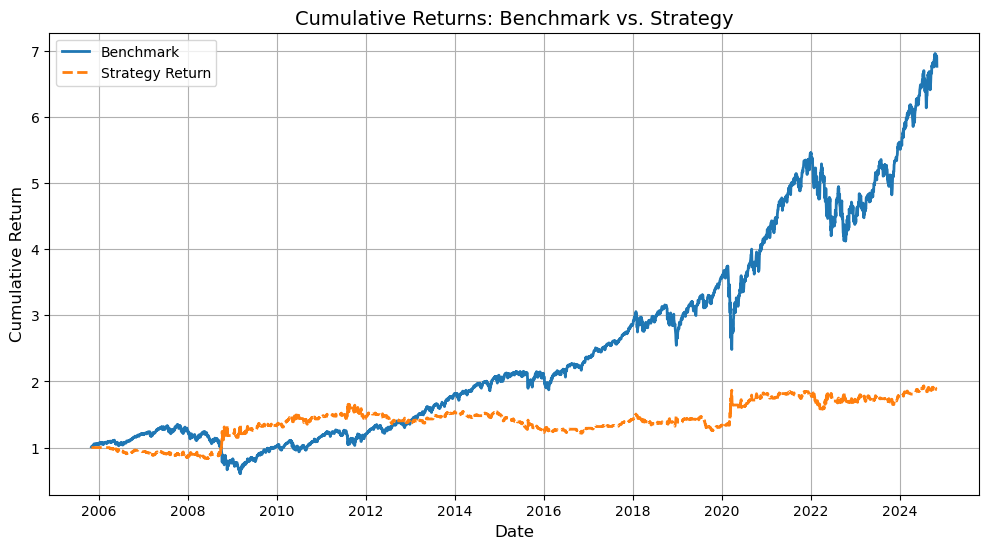

In [28]:
macd_sma_df, macd_sma_metrices = macd_sma_strategy(spy_data,15,39,6,99)
print(macd_sma_metrices)
visualize_returns(macd_sma_df)

### <a id="strategy-6">6. KDJ + Moving Average Convergence Divergence</a>
[🔝 Back to Table of Contents](#top)

In [29]:
def kdj_macd_strategy(
    data,
    kdj_lookback=14,
    k_smoothing=3,
    d_smoothing=3,
    macd_short_window=12,
    macd_long_window=26,
    macd_signal_window=9,
):
    data = data.copy()

    # Ensure required column exists
    if "Adj Close" not in data.columns:
        raise ValueError("Input data must contain 'Adj Close' column.")

    # --- KDJ Calculations ---
    # Calculate Lowest Low and Highest High for KDJ
    data["low_min"] = data["Adj Close"].rolling(window=kdj_lookback).min()
    data["high_max"] = data["Adj Close"].rolling(window=kdj_lookback).max()

    # Calculate %K
    data["%K"] = 100 * (data["Adj Close"] - data["low_min"]) / (data["high_max"] - data["low_min"])
    data["%K"] = data["%K"].rolling(window=k_smoothing).mean()  # Smooth %K

    # Calculate %D
    data["%D"] = data["%K"].rolling(window=d_smoothing).mean()

    # Calculate %J
    data["%J"] = 3 * data["%K"] - 2 * data["%D"]

    # --- MACD Calculations ---
    # Calculate EMAs for MACD
    data["ema_short"] = data["Adj Close"].ewm(span=macd_short_window, adjust=False).mean()
    data["ema_long"] = data["Adj Close"].ewm(span=macd_long_window, adjust=False).mean()

    # Calculate MACD and Signal Line
    data["macd"] = data["ema_short"] - data["ema_long"]
    data["signal_line"] = data["macd"].ewm(span=macd_signal_window, adjust=False).mean()

    # --- Combined Strategy Logic ---
    data["positions"] = 0

    # Buy Signal: KDJ indicates oversold (%J < 20) and MACD is bullish (MACD > Signal Line)
    data.loc[(data["%J"] < 20) & (data["macd"] > data["signal_line"]), "positions"] = 1

    # Sell Signal: KDJ indicates overbought (%J > 80) and MACD is bearish (MACD < Signal Line)
    data.loc[(data["%J"] > 80) & (data["macd"] < data["signal_line"]), "positions"] = -1

    # Calculate performance metrics
    metrics = calculate_performance_metrics(data)

    # Drop NaN values from rolling calculations
    data = data.dropna(subset=["%K", "%D", "%J", "macd", "signal_line", "positions"])

    return data, metrics

In [30]:
kdj_macd_param_bounds = {
    "kdj_lookback": (5, 30),
    "k_smoothing": (1, 10),
    "d_smoothing": (1, 10),
    "macd_short_window": (8, 16),
    "macd_long_window": (20, 40),
    "macd_signal_window": (5, 15),
}

In [31]:
optimize_strategy(spy_train, kdj_macd_strategy, kdj_macd_param_bounds)

{'params': {'d_smoothing': 8,
  'k_smoothing': 1,
  'kdj_lookback': 5,
  'macd_long_window': 21,
  'macd_short_window': 14,
  'macd_signal_window': 13},
 'metrics': {'Sharpe Ratio': 0.6450893990732848,
  'CAGR': 0.07214055716732104,
  'Final Capital': 287628.3178427395,
  'Max Drawdown': 0.47849449087754525}}

{'Sharpe Ratio': 0.573578821584259, 'CAGR': 0.06235549011549124, 'Final Capital': 315802.34797271155, 'Max Drawdown': 0.47849449087754525}


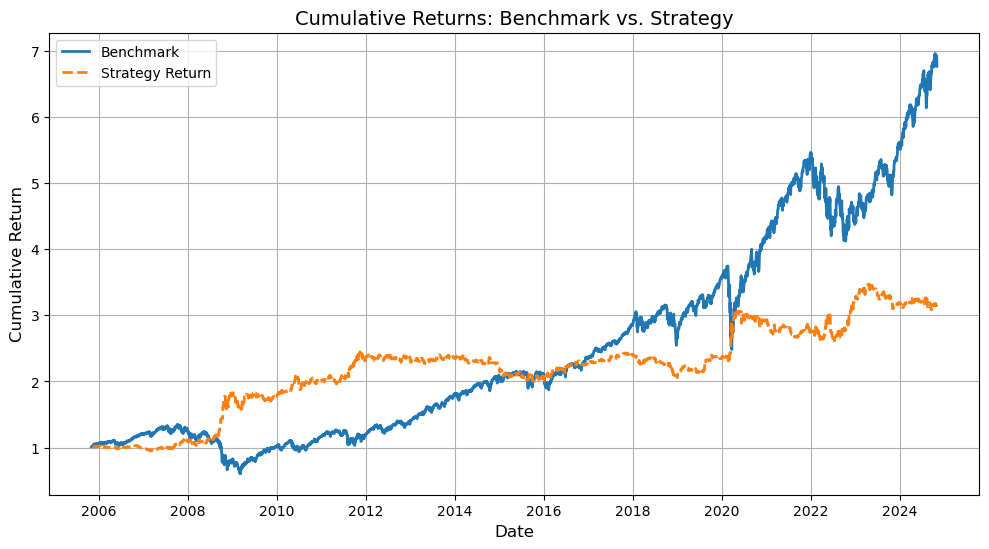

In [32]:
kdj_macd_df, kdj_macd_metrices = kdj_macd_strategy(spy_data,5,1,8,14,21,13)
print(kdj_macd_metrices)
visualize_returns(kdj_macd_df)

## <a id="best-three-strategies-and-their-results">**Best Three Strategies and Their Results**</a>
[🔝 Back to Table of Contents](#top)


<a id="strategy-1">1. Simple Moving Average Crossover</a>


<a id="strategy-3">2. Mean Reversion</a>


<a id="strategy-4">3. SMA+Bollinger Bands</a>

In [33]:
all_metrics = {
    "Simple Moving Average Crossover": sma_metrices,
    "Relative Strength Index + SMA": rsi_sma_metrices,
    "Mean Reversion": mr_metrices,
    "SMA + Bollinger Bands": sma_bollinger_metrices,
    "MACD + SMA": macd_sma_metrices,
    "KDJ + MACD": kdj_macd_metrices,
}

# Convert combined metrics into a DataFrame
metrics_df = pd.DataFrame(all_metrics).T

In [34]:
metrics_df.sort_values(by="Final Capital", ascending=False)

,Sharpe Ratio,CAGR,Final Capital,Max Drawdown
Simple Moving Average Crossover,0.516581,0.084661,468787.582215,1.043652
Mean Reversion,0.533402,0.069804,359600.543628,2.001876
SMA + Bollinger Bands,0.710700,0.068782,342925.239212,0.428969
KDJ + MACD,0.573579,0.062355,315802.347973,0.478494
Relative Strength Index + SMA,0.620388,0.052506,264552.378595,0.611482
MACD + SMA,0.295518,0.033761,187992.066440,0.440486


#### Sharpe Ratio
- SMA + Bollinger Bands (0.71):

Has the highest Sharpe Ratio, indicating that this strategy provides the best return relative to the risk taken.
Suggests a more consistent return profile compared to the other strategies.
- Mean Reversion (0.53):

Moderate Sharpe Ratio, reflecting a less effective risk-adjusted return compared to SMA + Bollinger Bands.
Likely more prone to volatility and potentially noisy signals.
- Simple Moving Average Crossover (0.52):

Lowest Sharpe Ratio among the three.
Indicates that returns are less efficient when adjusted for risk compared to the other strategies.

#### CAGR (Compound Annual Growth Rate)

- Simple Moving Average Crossover (8.46%):

Shows the highest CAGR, meaning it delivered the best long-term growth among the three strategies.
Indicates strong upward trends in the underlying asset.

- SMA + Bollinger Bands (6.88%):

Slightly lower CAGR compared to the Simple Moving Average Crossover.
Likely more cautious or focused on reducing drawdowns rather than maximizing growth.
- Mean Reversion (6.98%):

The lowest CAGR, suggesting it was less effective at generating consistent long-term growth.

#### Maximum Drawdown

- SMA + Bollinger Bands (0.43):

Lowest drawdown, indicating this strategy experienced the least severe losses during its worst-performing period.
Reflects more robust risk management or better alignment with market conditions.
- Simple Moving Average Crossover (1.04):

Moderate drawdown, which is manageable but still higher than SMA + Bollinger Bands.
Indicates potential exposure to adverse market conditions.
- Mean Reversion (2.00):

Highest drawdown, reflecting significant losses during its worst-performing period.
Suggests vulnerability to market trends or volatility.

## <a id="critiques">**Critiques**</a>
[🔝 Back to Table of Contents](#top)


### 1. Strategy-Specific Critiques
#### **1. Simple Moving Average Crossover**
- **Strengths**:
  - Captures trends effectively in strongly trending markets (e.g., bull or bear markets).
  - Simple to implement and interpret.
- **Weaknesses**:
  - Performs poorly in range-bound or choppy markets due to frequent whipsaws.
  - Lagging indicator, leading to delayed entries and exits.
  - Limited adaptability to rapidly changing market conditions.
- **Recommendations**:
  - Combine with momentum indicators like MACD to confirm trends and reduce false signals.
  - Explore adaptive moving averages (e.g., EMA) to reduce lag.

#### **2. Relative Strength Index + Simple Moving Average**
- **Strengths**:
  - Combines momentum (RSI) and trend confirmation (SMA), reducing false signals.
  - RSI ensures trades are not executed in overbought/oversold conditions, providing better timing.
- **Weaknesses**:
  - RSI thresholds can be static and fail to adapt to varying market conditions.
  - Struggles in periods of extreme market volatility when trends dominate over mean reversion.
- **Recommendations**:
  - Introduce dynamic RSI thresholds that adjust to market volatility or trend strength.
  - Incorporate Bollinger Bands for better signal filtering during high-volatility periods.

#### **3. Mean Reversion**
- **Strengths**:
  - Exploits short-term price deviations, making it effective in range-bound markets.
  - Profits from price corrections when the market reverts to the mean.
- **Weaknesses**:
  - Vulnerable to losses in strongly trending markets where prices deviate further from the mean.
  - Sensitive to parameter choices (e.g., lookback period) and prone to overfitting.
- **Recommendations**:
  - Use volatility filters (e.g., ATR or VIX) to avoid trades during strong trends.
  - Combine with trend-following components to improve robustness in diverse market conditions.

#### **4. SMA + Bollinger Bands**
- **Strengths**:
  - Combines trend-following (SMA) with volatility-based breakout or mean-reversion signals (Bollinger Bands).
  - Performs well in volatile markets by capturing price extremes.
- **Weaknesses**:
  - Prone to false signals in low-volatility environments.
  - Bollinger Bands are static and do not adapt well to different market phases.
- **Recommendations**:
  - Introduce regime detection (e.g., volatility measures) to adapt Bollinger Band parameters dynamically.
  - Combine with momentum indicators like MACD for trend confirmation.

#### **5. Moving Average Convergence Divergence + Simple Moving Average**
- **Strengths**:
  - MACD provides momentum confirmation, while SMA ensures trades align with the prevailing trend.
  - Reduces false signals in trending markets compared to standalone MACD.
- **Weaknesses**:
  - Delayed signals due to reliance on moving averages, leading to missed opportunities in fast-moving markets.
  - Struggles in highly volatile or sideways markets where momentum signals can be misleading.
- **Recommendations**:
  - Add a mean-reversion filter (e.g., RSI or Bollinger Bands) to reduce false signals in sideways markets.
  - Experiment with adaptive MACD parameters for dynamic market conditions.

#### **6. KDJ + Moving Average Convergence Divergence**
- **Strengths**:
  - KDJ captures overbought/oversold conditions effectively, while MACD confirms momentum.
  - Balanced approach for identifying trend reversals and continuations.
- **Weaknesses**:
  - Highly sensitive to parameter tuning, making it prone to overfitting.
  - Limited robustness in extreme market conditions where trends dominate over oscillations.
- **Recommendations**:
  - Introduce a volatility filter to avoid signals during extreme market moves.
  - Use walk-forward validation to reduce overfitting and improve robustness.

---

### 2. Biases in Backtesting

#### **Survivorship Bias**
As the analysis over 20 years, there are companies that got delisted and this approach of backtesting will result in Survivorship bias. 

**Impact**:
- Survivorship bias likely overstates the performance of our strategies by excluding underperforming or delisted companies.
- This may create a false sense of robustness and reliability in strategy performance.

**Recommendations**:
- Incorporate historical constituents of the S&P 500 into backtesting to include companies that were delisted or removed.
- Use broader indices or ETFs (e.g., SPY) to ensure a representative sample of the market.

---

#### **Lookahead Bias**
The Strategies are only shifted 1 which means it is not realistic as in real, the data may not be fully accessible.

**Impact**:
- Lookahead bias inflates strategy performance by using future or finalized data unavailable at the time of trading.
- Results may overstate the strategies' accuracy and reliability.

**Recommendations**:
- Use lagged economic data or forecasts that mimic the information available at the time.
- Conduct real-time simulations to ensure strategies operate under realistic conditions.

---

#### **Market Regime Shift**

Over the 20 years, the market has encountered different shift due to events, such as the 2008 financial crisis, the subsequent bull market, and the COVID-19 pandemic, this could have impact on our strategies and optimizations.

**Impact**:
- Strategies optimized for one regime may fail in others (e.g., trend-following strategies during sideways markets).
- Results may not generalize across diverse market conditions.

**Recommendations**:
- Incorporate regime-switching models to detect market phase changes dynamically.
- Combine multiple strategies (e.g., trend-following and mean-reversion) to ensure robustness across regimes.

---

### 3. Overfitting in Optimization
As our strategies were optimized using training data, they are prone to overfitting, leading to poor performance on test data. 

**Recommendations**:
- Use rolling-window backtesting or walk-forward optimization to minimize overfitting.
- Focus on simpler models with fewer parameters to ensure better generalization.

---

### 4. Challenges of Beating SPY
SPY is a well-diversified index with strong historical performance. Achieving consistent outperformance with simple strategies is challenging due to:
- High efficiency of markets.
- Limited alpha opportunities in broad-market indices.

Due to the lack of time in this project and knowledge, we were unable to explore more into the machine learning sector to perform hyperparameter tuning and advanced optimization.

**Recommendations**:
- Future work should focus on leveraging advanced machine learning models to identify non-linear patterns and alpha sources.
- Explore alternative data sources (e.g., sentiment analysis, macroeconomic indicators) to enhance prediction accuracy.

---htful, highlight the need for more advanced tools and methodologies to achieve consistent outperformance in the future.


## <a id="contribution-statement">**Contribution Statement**</a>
[🔝 Back to Table of Contents](#top)

 We(Tingjia LU, Yonghan Zhang): set out to design and implement various quantitative trading strategies, including baseline and momentum-based approaches. The goal was to backtest and evaluate their performance under different market conditions while presenting the results through clear and insightful visualizations. We were responsible for developing the SMA Crossover, MACD, and RSI strategies. For each of these momentum strategies, we completed all aspects of the project, including data downloading and preprocessing, strategy design and signal generation, performance evaluation, and result visualization. Additionally, we also attempted a combination strategy using MACD and RSI, but the results were less effective than expected. 

Li Ruoyao: Primarily responsible for the mean reversion section of the project, although the initial strategy results were not ideal. Through ongoing discussions with another team member, two combined strategies were added, leading to satisfactory results. Actively engaged in discussions with team members to address issues and contributed to optimizing the strategy outcomes.

Phoo Pyae Hsu Myat: My contribution involved unifying the provided strategies, defining functions to ensure the consistent flow in the implementation and evaluation. I assisted in optimizing the strategies to improve their performance metrics and practical applicability. Additionally, I explored machine learning approaches to enhance the strategies, but the results were not satisfactory. Due to time constraints, I was unable to continue with feature engineering and further fine-tuning of the machine learning models.

In the final stage, we combined all the trading strategies and conducted a comprehensive comparative analysis of their performance. We successfully met all project requirements through effective teamwork and code integration.